# This is implementation with pure Keras

## Has automated feature selection using RFECV.

### Has shuffling, normalisation, udf for model training, reproducibility

Validation data is passed as some pct of the training data, for early stopping rounds. And then finally predictions are made on unseen test data.

In [1]:
# Load Keras libraries used in this example

import keras
from keras import metrics
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random as rn
from keras import backend as K
from sklearn.model_selection import train_test_split

# Loding data

In [3]:
all_data = pd.read_csv('data/train.csv')
all_data.shape

(1460, 81)

In [4]:
#separate the output column from the rest of your data
# prices=all_data['SalePrice']
# all_data.drop('SalePrice',axis=1,inplace=True)

In [4]:

# Dropping the id column
all_data.drop('Id',axis=1,inplace=True)

# all_data.drop('MSSubClass',axis=1,inplace=True)
all_data.shape

(1460, 80)

In [5]:
# #Feature selection should be done after data preprocessing.
# #Ideally  all the categorical variables should be encoded into numbers, so that we can assess how deterministic they are for target.
# #Currently we will be dealling with numerical columns only.
# colType = ['int64','float64']
# #Select the columns which are either int64 or float64.
# numCols=list(all_data.select_dtypes(include=colType).columns)
# #Assigning numerical columns from df to data variable. We can use the same variable as well.
# num_data=all_data[numCols]
# num_data.shape

In [5]:
all_data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

# Handlig Missing values

In [6]:
all_data.isnull().sum().sort_values(ascending=False)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
LotFrontage       259
GarageType         81
GarageCond         81
GarageFinish       81
GarageQual         81
GarageYrBlt        81
BsmtFinType2       38
BsmtExposure       38
BsmtQual           37
BsmtCond           37
BsmtFinType1       37
MasVnrArea          8
MasVnrType          8
Electrical          1
RoofMatl            0
Exterior1st         0
RoofStyle           0
ExterQual           0
Exterior2nd         0
YearBuilt           0
ExterCond           0
Foundation          0
YearRemodAdd        0
SalePrice           0
OverallCond         0
                 ... 
GarageArea          0
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
3SsnPorch           0
BsmtUnfSF           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SaleType            0
Functional          0
TotRmsAbvGrd        0
KitchenQua

In [7]:
# Dropping the features with majority null values

# So, we will remove Alley, PoolQC, Fence and MiscFeature
all_data.drop('Alley', axis=1, inplace=True)
all_data.drop('PoolQC', axis=1, inplace=True)
all_data.drop('Fence', axis=1, inplace=True)
all_data.drop('MiscFeature', axis=1, inplace=True)

In [8]:
#FireplaceQu
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('NF') # No fireplace

#LotFrontage
# all_data['LotFrontage'].mode() ---> 60
all_data['LotFrontage'] = all_data['LotFrontage'].fillna(60)

# Basement columns
for col in ['BsmtFinType2','BsmtExposure','BsmtQual','BsmtFinType1','BsmtCond']:
    all_data[col] = all_data[col].fillna('NB') # No basement

# Garage columns
for col in ['GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond']:
    all_data[col] = all_data[col].fillna('NG') # No garage
    
# Dropping nans for the following cols
for col in ['MasVnrType','MasVnrArea','Electrical']:
    all_data.dropna(inplace=True)

In [9]:
all_data.isnull().sum().sort_values(ascending=False)

SalePrice        0
Foundation       0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
BsmtQual         0
SaleCondition    0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
RoofStyle        0
YearRemodAdd     0
YearBuilt        0
OverallCond      0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
                ..
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
GarageFinish     0
GarageType       0
CentralAir       0
FireplaceQu      0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath    

In [10]:
all_data.to_csv('train_no_null.csv',index=False)

# Handling Categorical Columns

In [11]:
all_data1 = pd.get_dummies(all_data)

In [12]:
all_data1.shape

(1451, 383)

# Train Test Split

In [13]:
def split_train_test(df,label_col,test_size=0.2):
    
    X = df.loc[:,df.columns != label_col]
    y = df[label_col]

    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=test_size, random_state=42)
    
    return train_x, test_x, train_y, test_y

In [14]:
train_x, test_x, train_y, test_y = split_train_test(all_data1,label_col='SalePrice')

In [15]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((1160, 382), (291, 382), (1160,), (291,))

# RFECV - Automated Feature Seclection

In [16]:
# from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor

In [16]:
# X = train_x.append(test_x)
# X, X_val = train_test_split()
# y = train_y.append(test_y)

In [17]:
train = pd.merge(train_x,pd.DataFrame(train_y),left_index=True,right_index=True)

In [18]:
X, X_val, Y, Y_val = split_train_test(train,label_col='SalePrice')

In [19]:
X_final = X.append(X_val)
Y_final = Y.append(Y_val)

In [30]:
estimator = RandomForestRegressor(random_state=42)
for x in [2,3,4,5,6,7,8,9,10]:
    selector = RFECV(estimator,cv=x,step=4,scoring='neg_mean_squared_error',verbose=0) # default values for cv and step are passed.
    selector = selector.fit(X_final, Y_final)
    print("----------",x,4,'----------')
    print(selector.n_features_)

---------- 2 4 ----------
50
---------- 3 4 ----------
126
---------- 4 4 ----------
290
---------- 5 4 ----------
158
---------- 6 4 ----------
118
---------- 7 4 ----------
70
---------- 8 4 ----------
322
---------- 9 4 ----------
350
---------- 10 4 ----------
166


In [31]:
estimator = RandomForestRegressor(random_state=42)
for x in [2,3,4,5,6,7,8,9,10]:
    selector = RFECV(estimator,cv=x+9,step=4,scoring='neg_mean_squared_error',verbose=0) # default values for cv and step are passed.
    selector = selector.fit(X_final, Y_final)
    print("----------",x+9,4,'----------')
    print(selector.n_features_)

---------- 11 4 ----------
126
---------- 12 4 ----------
322
---------- 13 4 ----------
334
---------- 14 4 ----------
90
---------- 15 4 ----------
126
---------- 16 4 ----------
286
---------- 17 4 ----------
162
---------- 18 4 ----------
226
---------- 19 4 ----------
158


In [33]:
estimator.fit(X_final,Y_final)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [34]:
estimator.feature_importances_

array([2.26362283e-03, 6.29200173e-03, 2.59189501e-02, 5.76187126e-01,
       4.75553639e-03, 1.18497093e-02, 6.49714808e-03, 3.79303906e-03,
       2.57642312e-02, 4.08418054e-04, 4.68175438e-03, 3.29008840e-02,
       2.36468961e-02, 3.20317766e-02, 2.43734912e-05, 8.53550490e-02,
       9.10731263e-04, 9.07062913e-05, 8.06569064e-03, 5.56082607e-04,
       1.58656157e-03, 3.03282759e-05, 4.86302691e-03, 3.05710718e-03,
       1.66877388e-02, 1.39523589e-02, 4.91613425e-03, 4.37979014e-03,
       9.17350438e-04, 1.25879547e-05, 1.30444635e-04, 6.57598473e-04,
       1.35091055e-05, 2.34177773e-03, 1.43806581e-03, 1.26787000e-04,
       1.40299144e-04, 8.94011416e-05, 7.92468095e-04, 1.44048207e-03,
       8.60342608e-06, 0.00000000e+00, 6.76516758e-04, 8.72917784e-04,
       8.54228344e-04, 3.13943092e-03, 8.49701293e-06, 2.27848641e-04,
       0.00000000e+00, 2.62990774e-03, 0.00000000e+00, 0.00000000e+00,
       5.46361562e-04, 7.25153944e-04, 3.05841325e-05, 0.00000000e+00,
      

In [27]:
# Number of selected features
selector.n_features_

272

In [24]:
# New feature matrix
selected_cols = []
for val,col in zip(selector.support_,X.columns):
    if(val == True):
        selected_cols.append(col)
        
train_x1 = train_x[selected_cols]
test_x1 = test_x[selected_cols]

In [25]:
train_x1.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'MoSold', 'YrSold', 'MSZoning_RL', 'MSZoning_RM',
       'LotShape_IR1', 'LotShape_Reg', 'LandContour_Lvl', 'LotConfig_Corner',
       'LotConfig_CulDSac', 'LotConfig_Inside', 'LandSlope_Mod',
       'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr',
       'Neighborhood_Crawfor', 'Neighborhood_NWAmes', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Condition1_Norm', 'RoofStyle_Gable',
       'RoofStyle_Hip', 'Exterior1st_BrkFace', 'Exterior1st_Wd Sdng',
       'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard', 'Exterior2nd_VinylSd',
       'MasVnrType_BrkFace'

# Create the model

Let's build our model. Here, we'll use a Sequential model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, build_model, since we'll create a second model, later on.

In [26]:
def build_model(train_x):
    
#     model = Sequential()
#     print('No of input features',train_x.shape[1])
#     model.add(Dense(128,activation="relu",input_shape=(train_x.shape[1],)))
#     model.add(Dense(64,activation="relu"))
#     model.add(Dense(1))
    
#     model.compile(loss='mean_squared_error',
#                     optimizer=RMSprop(lr=0.001),
#                     metrics=[metrics.mae])
#     print(model.summary())

    model = Sequential()
    BatchNormalization()
    model.add(Dense(1028,input_dim=train_x.shape[1],activation='relu'))
#     BatchNormalization()
#     model.add(Dense(1028,input_dim=train_x.shape[1],activation='relu'))
#     BatchNormalization()
    #Dropout(0.2)
    model.add(Dense(100,activation='relu'))
    BatchNormalization()
    #Dropout(0.2)
    model.add(Dense(50))
    BatchNormalization()
    model.add(Dense(1))
    model.compile(optimizer='adam',loss='mse',metrics=[metrics.mae])
    return model

# Train the model

In [27]:
def model_train(model, train_x, train_y, epochs=500, batch_size=100,valid_pct=0.2, early_stopping_rounds = 20,verbose=0):
    
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stopping_rounds)
    
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size,
                    validation_split=valid_pct, verbose=verbose,
                    callbacks=[early_stop])
    
    [loss, mae] = model.evaluate(test_x1, test_y, verbose=0)

    print("Testing set Mean Abs Error: {:7.2f}".format(mae))
    print("Testing set Root Mean Sqd Error : {:7.2f}".format((loss ** 0.5)))
    
    return loss,mae

In [28]:
import os
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

model = build_model(train_x=train_x1)

loss,mae = model_train(model=model, train_x=train_x1, train_y=train_y, epochs=500, batch_size=128, valid_pct=0.2, early_stopping_rounds = 50, verbose=2)

Train on 928 samples, validate on 232 samples
Epoch 1/500
 - 0s - loss: 37213326865.6552 - mean_absolute_error: 175675.0878 - val_loss: 33209764546.2069 - val_mean_absolute_error: 165331.9046
Epoch 2/500
 - 0s - loss: 29198323147.0345 - mean_absolute_error: 152216.9906 - val_loss: 20939517316.4138 - val_mean_absolute_error: 125823.8521
Epoch 3/500
 - 0s - loss: 17011654585.3793 - mean_absolute_error: 102948.3540 - val_loss: 6727591794.7586 - val_mean_absolute_error: 58023.8213
Epoch 4/500
 - 0s - loss: 12625034098.7586 - mean_absolute_error: 56984.8921 - val_loss: 4191630768.5517 - val_mean_absolute_error: 45754.8089
Epoch 5/500
 - 0s - loss: 10705442780.6897 - mean_absolute_error: 50826.6848 - val_loss: 4050078799.4483 - val_mean_absolute_error: 43732.8485
Epoch 6/500
 - 0s - loss: 7108340700.6897 - mean_absolute_error: 46907.0567 - val_loss: 3812934223.4483 - val_mean_absolute_error: 42427.8916
Epoch 7/500
 - 0s - loss: 5702589563.5862 - mean_absolute_error: 44319.5966 - val_loss: 33

Epoch 58/500
 - 0s - loss: 2060285298.7586 - mean_absolute_error: 27222.8033 - val_loss: 1456835879.7241 - val_mean_absolute_error: 26644.1552
Epoch 59/500
 - 0s - loss: 2064193571.3103 - mean_absolute_error: 27102.4710 - val_loss: 1441170685.7931 - val_mean_absolute_error: 26569.3603
Epoch 60/500
 - 0s - loss: 2044690414.3448 - mean_absolute_error: 26980.3895 - val_loss: 1452508294.6207 - val_mean_absolute_error: 26636.7846
Epoch 61/500
 - 0s - loss: 2036821945.3793 - mean_absolute_error: 26971.9441 - val_loss: 1438350927.4483 - val_mean_absolute_error: 26460.0758
Epoch 62/500
 - 0s - loss: 2011157495.1724 - mean_absolute_error: 27084.9192 - val_loss: 1439535673.3793 - val_mean_absolute_error: 26427.9580
Epoch 63/500
 - 0s - loss: 1998131520.0000 - mean_absolute_error: 26862.9860 - val_loss: 1428066021.5172 - val_mean_absolute_error: 26331.8557
Epoch 64/500
 - 0s - loss: 1990344553.9310 - mean_absolute_error: 26940.0855 - val_loss: 1433387912.8276 - val_mean_absolute_error: 26403.7890

Epoch 116/500
 - 0s - loss: 1571894942.8966 - mean_absolute_error: 25517.4702 - val_loss: 1383887814.6207 - val_mean_absolute_error: 24751.4967
Epoch 117/500
 - 0s - loss: 1557177359.4483 - mean_absolute_error: 25314.5000 - val_loss: 1358864476.6897 - val_mean_absolute_error: 24896.6057
Epoch 118/500
 - 0s - loss: 1547212115.8621 - mean_absolute_error: 25417.3919 - val_loss: 1364926576.5517 - val_mean_absolute_error: 24588.9949
Epoch 119/500
 - 0s - loss: 1585827802.4828 - mean_absolute_error: 25798.6635 - val_loss: 1356484073.9310 - val_mean_absolute_error: 24542.3920
Epoch 120/500
 - 0s - loss: 1569879428.4138 - mean_absolute_error: 25854.2592 - val_loss: 1391025257.9310 - val_mean_absolute_error: 26010.4114
Epoch 121/500
 - 0s - loss: 1627281959.7241 - mean_absolute_error: 26200.2128 - val_loss: 1409974494.8966 - val_mean_absolute_error: 24794.5130
Epoch 122/500
 - 0s - loss: 1575685446.6207 - mean_absolute_error: 25507.7682 - val_loss: 1398667520.0000 - val_mean_absolute_error: 245

Epoch 173/500
 - 0s - loss: 1298212740.4138 - mean_absolute_error: 24177.2812 - val_loss: 1347239185.6552 - val_mean_absolute_error: 23376.4895
Epoch 174/500
 - 0s - loss: 1323226063.4483 - mean_absolute_error: 24618.2724 - val_loss: 1348663092.9655 - val_mean_absolute_error: 25152.6788
Epoch 175/500
 - 0s - loss: 1278377745.6552 - mean_absolute_error: 24177.0890 - val_loss: 1319752843.0345 - val_mean_absolute_error: 23874.2458
Epoch 176/500
 - 0s - loss: 1241138749.7931 - mean_absolute_error: 23705.6695 - val_loss: 1304878333.7931 - val_mean_absolute_error: 23522.3201
Epoch 177/500
 - 0s - loss: 1237405113.3793 - mean_absolute_error: 23702.9589 - val_loss: 1386988839.7241 - val_mean_absolute_error: 23567.2315
Epoch 178/500
 - 0s - loss: 1260520483.3103 - mean_absolute_error: 24028.2602 - val_loss: 1323245040.5517 - val_mean_absolute_error: 24322.8074
Epoch 179/500
 - 0s - loss: 1228877943.1724 - mean_absolute_error: 23635.4357 - val_loss: 1303726011.5862 - val_mean_absolute_error: 234

Epoch 230/500
 - 0s - loss: 1048374810.4828 - mean_absolute_error: 21991.8904 - val_loss: 1206538866.7586 - val_mean_absolute_error: 23197.6092
Epoch 231/500
 - 0s - loss: 1050434513.6552 - mean_absolute_error: 21874.5311 - val_loss: 1223509181.7931 - val_mean_absolute_error: 22269.0110
Epoch 232/500
 - 0s - loss: 1033924113.6552 - mean_absolute_error: 21864.1332 - val_loss: 1304511022.3448 - val_mean_absolute_error: 22451.8071
Epoch 233/500
 - 0s - loss: 1095883422.8966 - mean_absolute_error: 22736.3902 - val_loss: 1319245340.6897 - val_mean_absolute_error: 23081.7363
Epoch 234/500
 - 0s - loss: 1120675685.5172 - mean_absolute_error: 22706.4281 - val_loss: 1260959770.4828 - val_mean_absolute_error: 22019.8211
Epoch 235/500
 - 0s - loss: 1065179127.1724 - mean_absolute_error: 22363.5210 - val_loss: 1181041942.0690 - val_mean_absolute_error: 22800.3794
Epoch 236/500
 - 0s - loss: 1064083102.8966 - mean_absolute_error: 22006.7975 - val_loss: 1288926883.3103 - val_mean_absolute_error: 244

 - 0s - loss: 932622155.0345 - mean_absolute_error: 21071.3342 - val_loss: 1098013974.0690 - val_mean_absolute_error: 21285.6693
Epoch 288/500
 - 0s - loss: 845816960.0000 - mean_absolute_error: 19926.2831 - val_loss: 1078151920.5517 - val_mean_absolute_error: 20553.4261
Epoch 289/500
 - 0s - loss: 877352328.8276 - mean_absolute_error: 20203.8609 - val_loss: 1134479668.9655 - val_mean_absolute_error: 21902.7642
Epoch 290/500
 - 0s - loss: 1021334355.8621 - mean_absolute_error: 22219.8566 - val_loss: 1149307021.2414 - val_mean_absolute_error: 20853.5962
Epoch 291/500
 - 0s - loss: 1017647593.9310 - mean_absolute_error: 21870.6727 - val_loss: 1091050396.6897 - val_mean_absolute_error: 21267.8204
Epoch 292/500
 - 0s - loss: 897117064.8276 - mean_absolute_error: 20619.7776 - val_loss: 1195605815.1724 - val_mean_absolute_error: 21955.5009
Epoch 293/500
 - 0s - loss: 899042189.2414 - mean_absolute_error: 20258.8045 - val_loss: 1064044215.1724 - val_mean_absolute_error: 20414.3018
Epoch 294/5

Epoch 345/500
 - 0s - loss: 744083553.1034 - mean_absolute_error: 18913.8296 - val_loss: 968225553.6552 - val_mean_absolute_error: 20043.3317
Epoch 346/500
 - 0s - loss: 733204025.3793 - mean_absolute_error: 18415.9262 - val_loss: 927742146.2069 - val_mean_absolute_error: 19244.3606
Epoch 347/500
 - 0s - loss: 725251740.6897 - mean_absolute_error: 18501.0483 - val_loss: 1045510980.4138 - val_mean_absolute_error: 19864.5723
Epoch 348/500
 - 0s - loss: 809368143.4483 - mean_absolute_error: 19233.2936 - val_loss: 1020217452.1379 - val_mean_absolute_error: 20607.9227
Epoch 349/500
 - 0s - loss: 769371405.2414 - mean_absolute_error: 19234.9121 - val_loss: 931289584.5517 - val_mean_absolute_error: 19301.1629
Epoch 350/500
 - 0s - loss: 711904518.6207 - mean_absolute_error: 18287.6644 - val_loss: 930273143.1724 - val_mean_absolute_error: 19587.1236
Epoch 351/500
 - 0s - loss: 682063399.7241 - mean_absolute_error: 17945.7965 - val_loss: 884602487.1724 - val_mean_absolute_error: 19050.6112
Epoc

Epoch 403/500
 - 0s - loss: 602033355.0345 - mean_absolute_error: 16981.4608 - val_loss: 819721968.5517 - val_mean_absolute_error: 18608.3584
Epoch 404/500
 - 0s - loss: 585430633.9310 - mean_absolute_error: 16661.4323 - val_loss: 790151858.7586 - val_mean_absolute_error: 18291.2075
Epoch 405/500
 - 0s - loss: 637109206.0690 - mean_absolute_error: 17653.5517 - val_loss: 945937118.8966 - val_mean_absolute_error: 20857.4412
Epoch 406/500
 - 0s - loss: 687360684.1379 - mean_absolute_error: 18228.9262 - val_loss: 933971339.0345 - val_mean_absolute_error: 21960.4087
Epoch 407/500
 - 0s - loss: 707011513.3793 - mean_absolute_error: 18195.0653 - val_loss: 941408996.4138 - val_mean_absolute_error: 19524.6303
Epoch 408/500
 - 0s - loss: 755778816.0000 - mean_absolute_error: 18864.8274 - val_loss: 809245261.2414 - val_mean_absolute_error: 18377.7144
Epoch 409/500
 - 0s - loss: 626714451.8621 - mean_absolute_error: 17439.9411 - val_loss: 824736014.3448 - val_mean_absolute_error: 18503.8237
Epoch 

Epoch 461/500
 - 0s - loss: 575044952.2759 - mean_absolute_error: 16881.6748 - val_loss: 760167606.0690 - val_mean_absolute_error: 18269.0068
Epoch 462/500
 - 0s - loss: 517324144.5517 - mean_absolute_error: 16277.3120 - val_loss: 833321007.4483 - val_mean_absolute_error: 19213.2460
Epoch 463/500
 - 0s - loss: 526497549.2414 - mean_absolute_error: 16041.8955 - val_loss: 845716546.2069 - val_mean_absolute_error: 19821.0271
Epoch 464/500
 - 0s - loss: 502474341.5172 - mean_absolute_error: 15944.4833 - val_loss: 808743004.6897 - val_mean_absolute_error: 18976.3641
Epoch 465/500
 - 0s - loss: 496215560.8276 - mean_absolute_error: 15741.2302 - val_loss: 853119145.9310 - val_mean_absolute_error: 19978.1437
Epoch 466/500
 - 0s - loss: 518445265.6552 - mean_absolute_error: 16255.0754 - val_loss: 773745732.4138 - val_mean_absolute_error: 18409.5061
Epoch 467/500
 - 0s - loss: 505476801.1034 - mean_absolute_error: 15714.6858 - val_loss: 744096003.3103 - val_mean_absolute_error: 17839.8752
Epoch 

# Predicting on the Test data

In [29]:
test_predictions = model.predict(test_x1).flatten()

In [30]:
predictions = pd.DataFrame(index=range(len(test_y)))
predictions['actual'] = pd.DataFrame(test_y.reset_index(drop=True))
predictions['preds'] = pd.DataFrame(test_predictions)

In [31]:
predictions

,actual,preds
0,315000,328521.218750
1,158900,153045.625000
2,127000,123761.484375
3,210000,188224.625000
4,260000,258769.203125
5,183200,197199.796875
6,185850,215825.828125
7,143500,135906.062500
8,165000,144119.984375
9,100000,122090.601562


In [32]:
# Mean and std of actual values in the test data.
predictions.actual.mean(), predictions.actual.std()

(179989.3883161512, 74821.7736464718)

In [33]:
# Percent error wrt to the mean actual price
print('Percent error: ',(loss ** 0.5)/predictions.actual.mean()*100,'%')

Percent error:  16.742958760712284 %


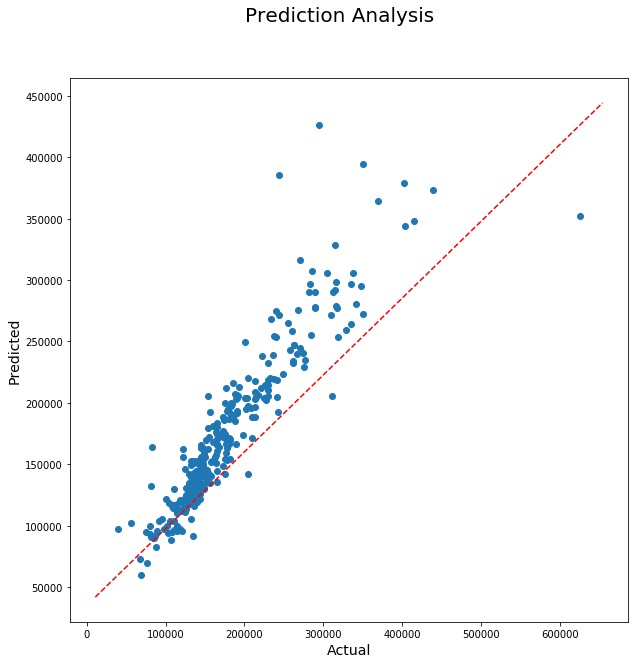

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(predictions.actual,predictions.preds)
fig.suptitle('Prediction Analysis', fontsize=20)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="r")
plt.xlabel('Actual', fontsize=14)
plt.ylabel('Predicted', fontsize=14)
plt.show()

# Conclusion

The results are worse than the case when all features are not passed to the model